<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Блэкджек-от-простого-к-настоящему" data-toc-modified-id="Блэкджек-от-простого-к-настоящему-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Блэкджек от простого к настоящему</a></span><ul class="toc-item"><li><span><a href="#Простой-блэкдек-с-openai" data-toc-modified-id="Простой-блэкдек-с-openai-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Простой блэкдек с openai</a></span><ul class="toc-item"><li><span><a href="#Простая-стратегия:-stand-при-комбинации-19,-20-или-21,--иначе-hit" data-toc-modified-id="Простая-стратегия:-stand-при-комбинации-19,-20-или-21,--иначе-hit-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Простая стратегия: stand при комбинации 19, 20 или 21,  иначе hit</a></span></li><li><span><a href="#Обучение-с-подкреплением-без-модели" data-toc-modified-id="Обучение-с-подкреплением-без-модели-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Обучение с подкреплением без модели</a></span></li><li><span><a href="#Средний-доход-метода" data-toc-modified-id="Средний-доход-метода-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Средний доход метода</a></span></li></ul></li><li><span><a href="#Блэкдек-с-действием-double" data-toc-modified-id="Блэкдек-с-действием-double-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Блэкдек с действием double</a></span></li><li><span><a href="#Блэкдек-с-запоминанием-карт" data-toc-modified-id="Блэкдек-с-запоминанием-карт-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Блэкдек с запоминанием карт</a></span></li><li><span><a href="#Блэкдек-с-double-и-split" data-toc-modified-id="Блэкдек-с-double-и-split-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Блэкдек с double и split</a></span></li></ul></li></ul></div>

# Блэкджек от простого к настоящему

In [33]:
import numpy as np
from functools import reduce
from operator import mul
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Простой блэкдек с openai

In [3]:
###############################
##    Simple BlackjackEnv    ##
###############################

import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

### Простая стратегия: stand при комбинации 19, 20 или 21,  иначе hit

In [4]:
num_starts = 1000000
result = []

env = BlackjackEnv(natural=True)

for i in tqdm(range(num_starts)):
    env.reset()
    while sum_hand(env.player) < 19:
        env.step(1)
    last = env.step(0)
    result.append(last[1])
print('\nMean result:{}'.format(np.array(result).mean()))

100%|██████████| 1000000/1000000 [01:47<00:00, 9325.77it/s]



Mean result:-0.044032


Text(0, 0.5, 'Средний выигрыш')

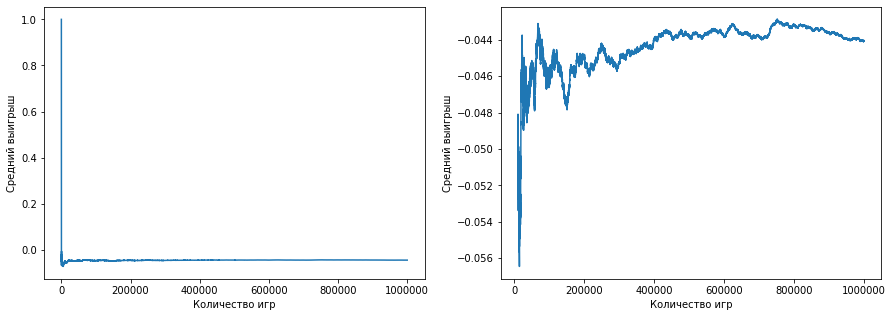

In [28]:
cum_sum = np.cum_sum(result)
iters = np.arange(1, cum_sum.shape[0] + 1)
cum_mean = cum_sum / iters

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(iters, cum_mean)
ax[0].set_xlabel('Количество игр')
ax[0].set_ylabel('Средний выигрыш')

ax[1].plot(iters[10000:], cum_mean[10000:])
ax[1].set_xlabel('Количество игр')
ax[1].set_ylabel('Средний выигрыш');

### Обучение с подкреплением без модели

In [ ]:
######################
##    Q-обучение    ##
######################

def compute_policy_by_Q(env, Q):
    return np.argmax( Q, axis=1 )
    
def get_s_basic(s, env):
    return s[0] - 1 + env.observation_space[0].n * (s[1]-1) +\
        env.observation_space[0].n * env.observation_space[1].n * s[2]

def Q_learning_episode(env, pi, Q, get_s, na, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env._get_obs(), pi[get_s(env._get_obs(), env)] if np.random.rand() > epsilon else np.random.randint(na)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime, a_prime = env._get_obs(), pi[get_s(env._get_obs(), env)] if np.random.rand() > epsilon else np.random.randint(na)
        Q[get_s(s, env)][a] = Q[get_s(s, env)][a] + alpha * (reward + gamma * np.max( Q[get_s(s_prime, env)] ) - Q[get_s(s, env)][a])
        s, a = s_prime, a_prime
        if done:
            return reward

def Q_learning(env, get_s, total_episodes, alpha, epsilon, gamma, has_split=False):
    na = env.action_space.n
    ns = reduce(mul, [dimention.n for dimention in env.observation_space])

    Q = np.random.random(size=(ns, na))

    pi = compute_policy_by_Q(env, Q)
    result = []
    rew = []

    for n in tqdm(range(total_episodes)):
        rew.append(Q_learning_episode(env, pi, Q, get_s, na, alpha=alpha, epsilon=epsilon, gamma=gamma))
        pi = compute_policy_by_Q(env, Q)
        if n % 10000 == 0 and n > 0:
            result.append(np.mean(rew))
            rew = []
    pi = compute_policy_by_Q(env, Q)

    return result, pi, env, Q

def calculate_MC_reward(num_starts, env, get_s, pi):

    result = []
    for i in tqdm(range(num_starts)):
        env.reset()
        s = env._get_obs()
        while True:
            s, reward, done, info = env.step(pi[get_s(s, env)])
            if done:
                result.append(reward)
                break
                
    return result

### Средний доход метода

100%|██████████| 1000000/1000000 [02:39<00:00, 6281.04it/s]


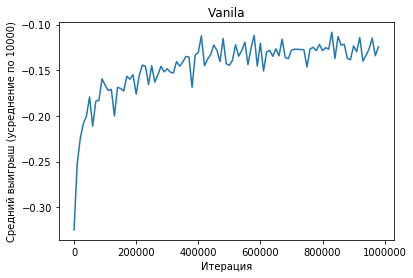

In [36]:
result_raw, pi_raw, env_raw, Q_raw = Q_learning(env=BlackjackEnv(natural=True),
                                                get_s=get_s_basic,
                                                total_episodes=1000000,
                                                alpha=0.001,
                                                epsilon=0.25,
                                                gamma=0.01)

plt.figure(figsize=(8,5))
plt.plot([i * 10000 for i in range(len(result_raw))], result_raw)
ax[0].set_xlabel('Количество игр')
plt.ylabel('Средний выигрыш (усреднение по 10000)')
plt.show()

##### Метод показывает результат лучше, чем у простой стратегии:

In [42]:
result = calculate_MC_reward(num_starts=1000000,
                    env=BlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_raw)

100%|██████████| 1000000/1000000 [01:39<00:00, 10089.71it/s]


In [43]:
print('\nMean result:{}'.format(np.array(result).mean()))


Mean result:-0.0374665


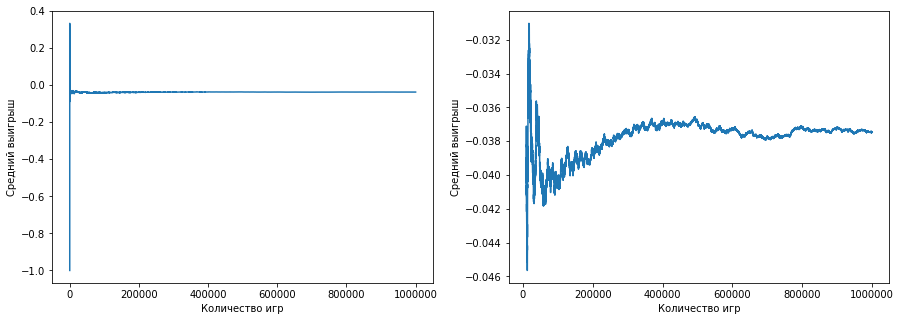

In [45]:
cum_sum = np.cumsum(result)
iters = np.arange(1, cum_sum.shape[0] + 1)
cum_mean = cum_sum / iters

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(iters, cum_mean)
ax[0].set_xlabel('Количество игр')
ax[0].set_ylabel('Средний выигрыш')

ax[1].plot(iters[10000:], cum_mean[10000:])
ax[1].set_xlabel('Количество игр')
ax[1].set_ylabel('Средний выигрыш');

## Блэкдек с действием double

In [55]:
###########################################
##    BlackjackEnv with double action    ##
###########################################


class DoubleBlackjackEnv(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # double action added
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0: # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: # double
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        else:
            pass
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

100%|██████████| 1000000/1000000 [02:10<00:00, 7647.45it/s]


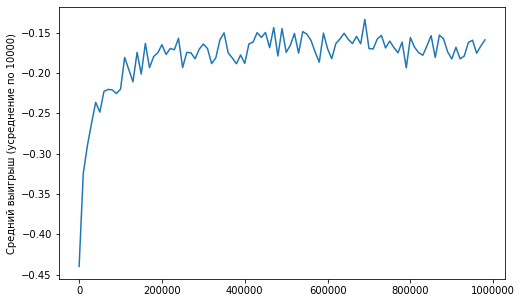

In [63]:
result_raw, pi_raw, env_raw, Q_raw = Q_learning(env=DoubleBlackjackEnv(natural=True),
                                                get_s=get_s_basic,
                                                total_episodes=1000000,
                                                alpha=0.005,
                                                epsilon=0.25,
                                                gamma=0.01)

plt.figure(figsize=(8,5))
plt.plot([i * 10000 for i in range(len(result_raw))], result_raw)
ax[0].set_xlabel('Количество игр')
plt.ylabel('Средний выигрыш (усреднение по 10000)')
plt.show()

In [64]:
result = calculate_MC_reward(num_starts=1000000,
                    env=DoubleBlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_raw)

100%|██████████| 1000000/1000000 [01:07<00:00, 14840.52it/s]


In [65]:
print('\nMean result:{}'.format(np.array(result).mean()))


Mean result:-0.016765


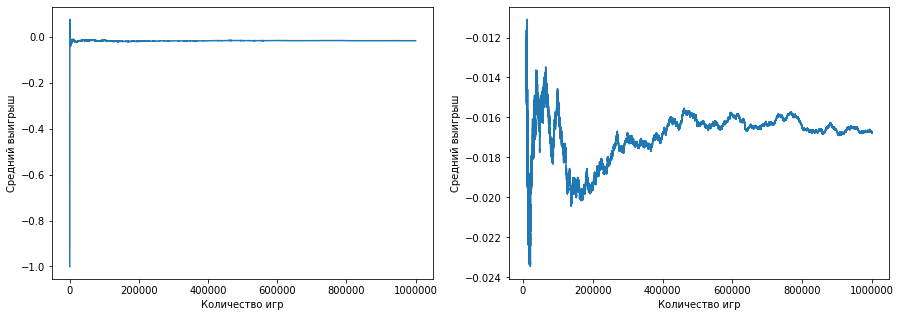

In [66]:
cum_sum = np.cumsum(result)
iters = np.arange(1, cum_sum.shape[0] + 1)
cum_mean = cum_sum / iters

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(iters, cum_mean)
ax[0].set_xlabel('Количество игр')
ax[0].set_ylabel('Средний выигрыш')

ax[1].plot(iters[10000:], cum_mean[10000:])
ax[1].set_xlabel('Количество игр')
ax[1].set_ylabel('Средний выигрыш');

## Блэкдек с запоминанием карт

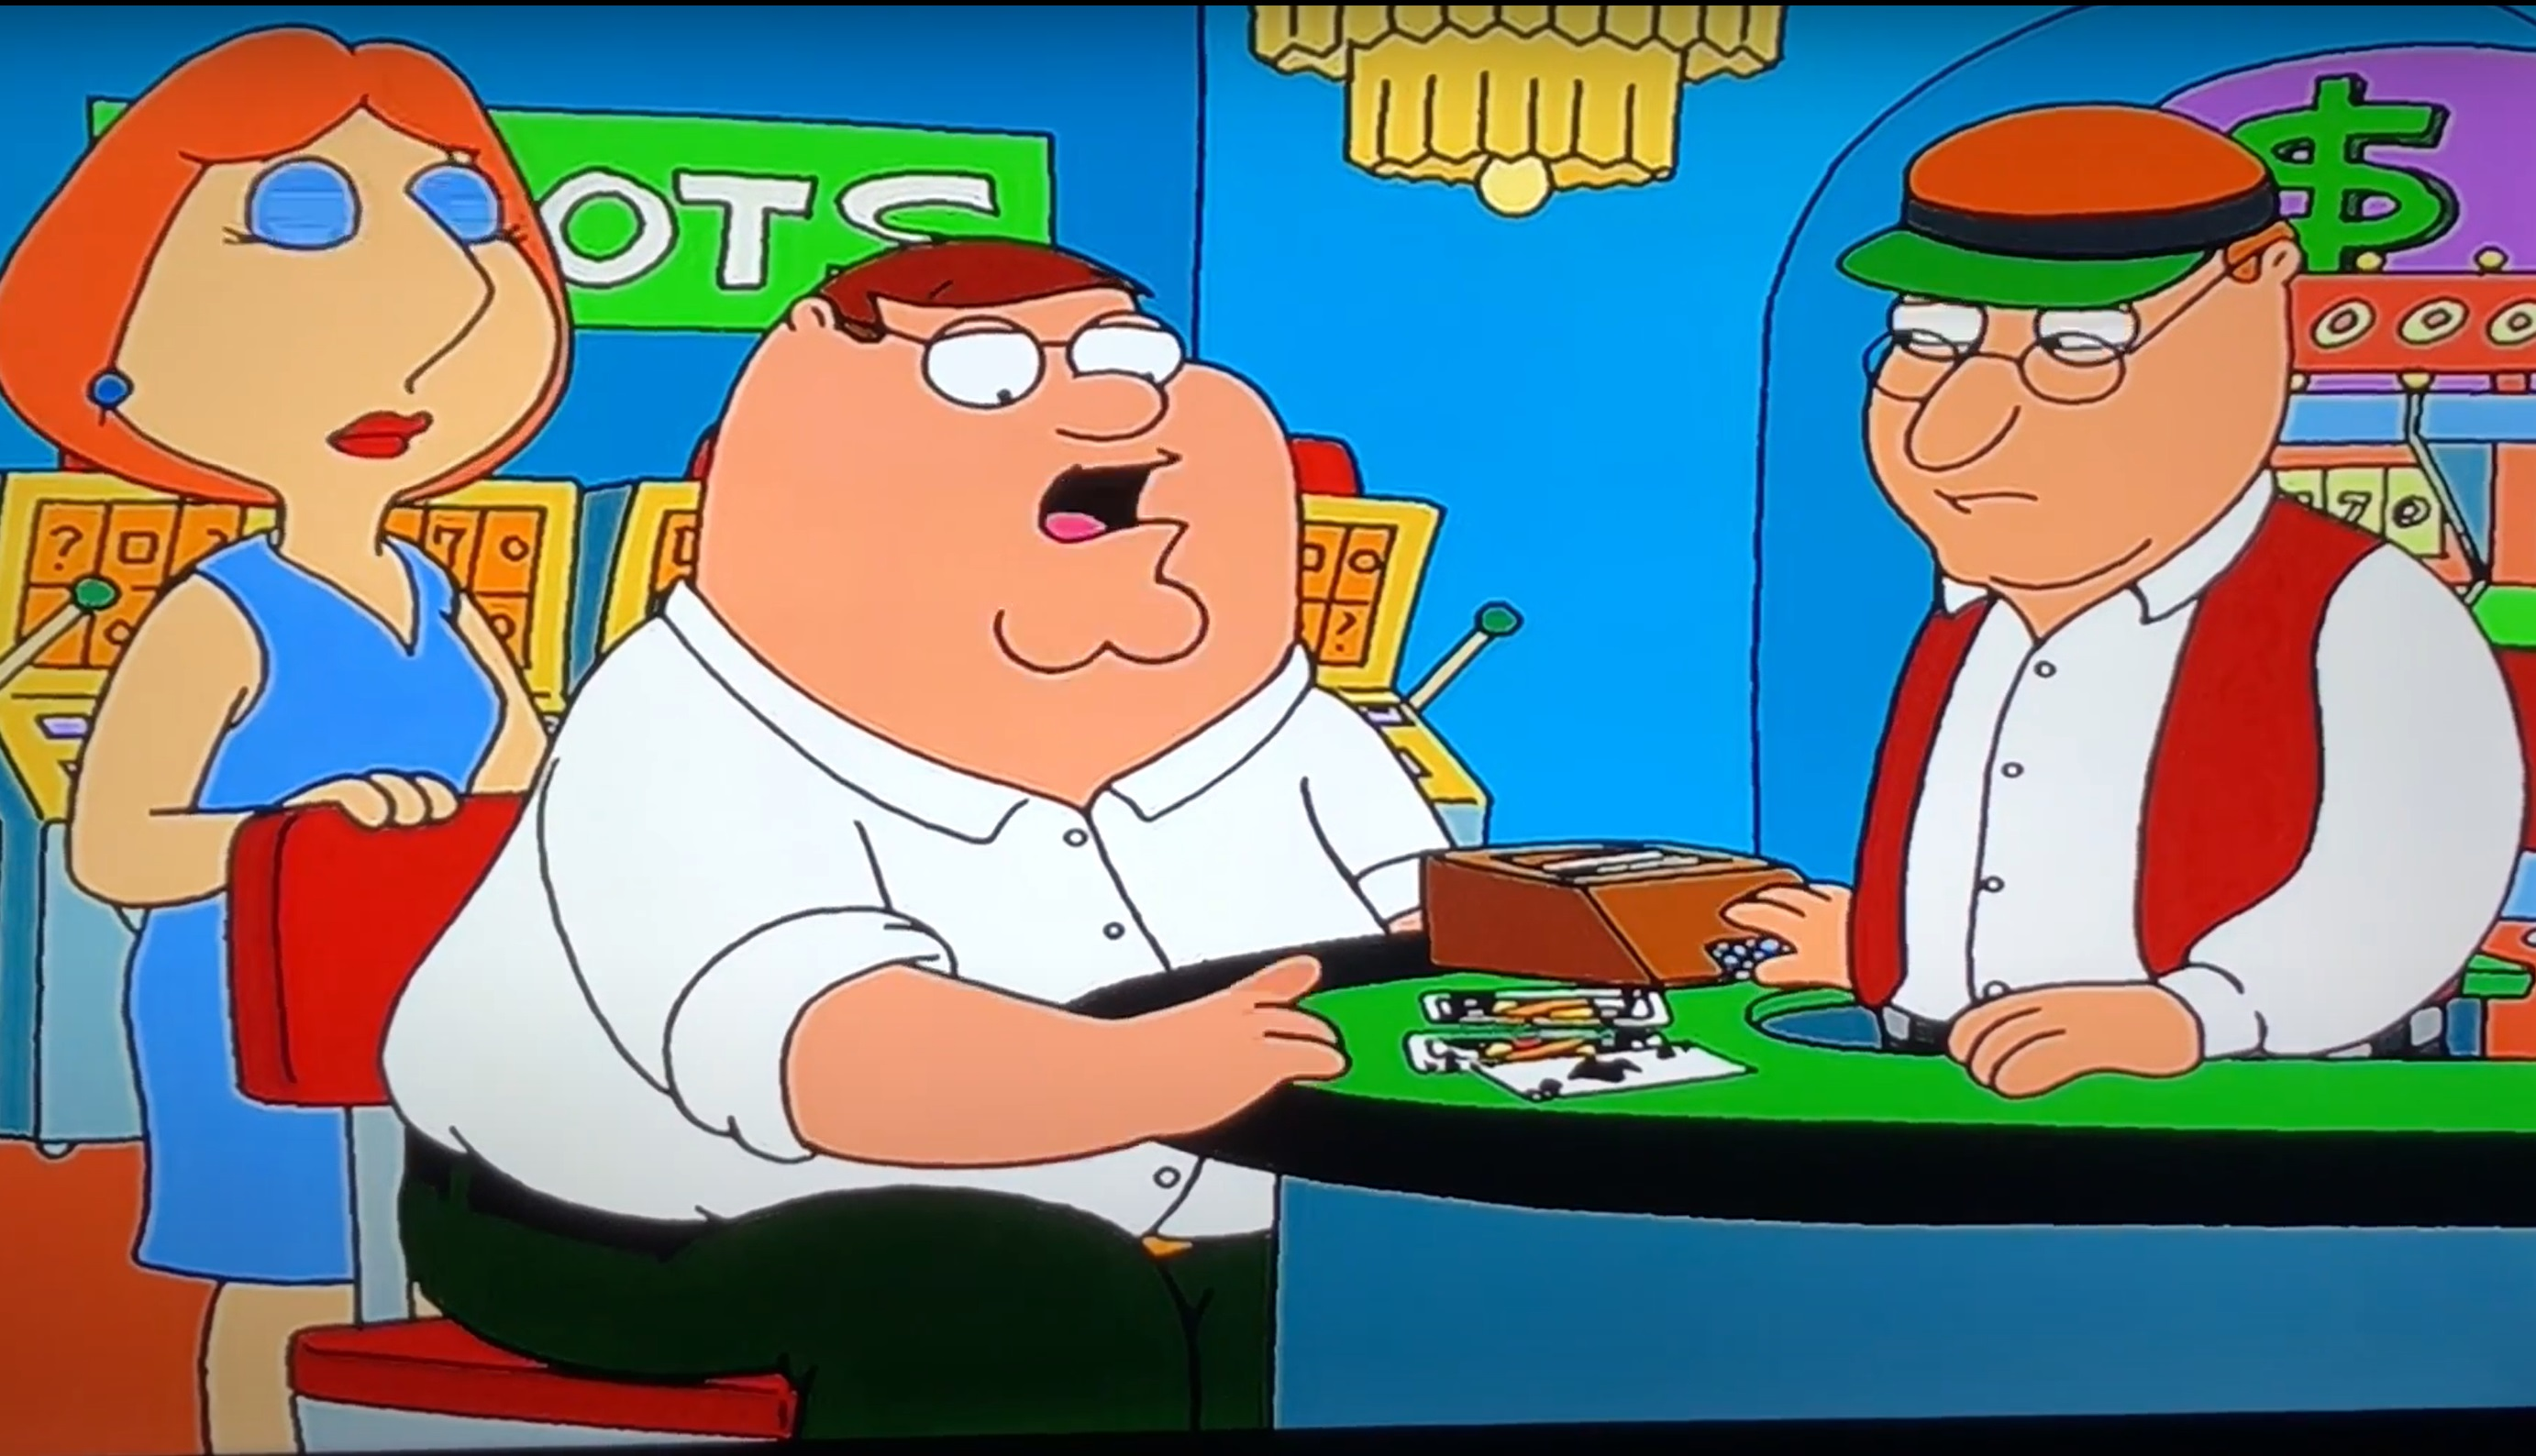

In [115]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "Peter.jpg", width=600, height=500)

In [107]:
###########################################################
##    BlackjackEnv with double action and cards count    ##
###########################################################

deck_full = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10
]

# Thorp's scores
scores = {
    1: -9,
    2: 5,
    3: 6,
    4: 8,
    5: 11,
    6: 6,
    7: 4,
    8: 0,
    9: -3,
    10: -7
}

# scrs = []
# for card in deck_full:
#     scrs.append(scores[card])
# scrs = np.array(sorted(scrs
# sum(scrs[scrs < 0])
# sum(scrs[scrs > 0])
# min value -160
# max value 160



class CardsCountDoubleBlackjackEnv(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # double action added
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(320)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.deck = deck_full.copy()
        self.deck_obs = 0;
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def draw_card(self):
        card = self.deck[self.np_random.choice(len(self.deck))]
        self.deck.remove(card)
        self.deck_obs += scores[card]
        if len(self.deck) <= 15:
            self.deck = deck_full.copy()
            self.deck_obs = 0
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0: # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: # double
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        else:
            pass
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.deck_obs)

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [127]:
def get_s_basic(s, env):
    return s[0] - 1 + env.observation_space[0].n * (s[1]-1) +\
        env.observation_space[0].n * env.observation_space[1].n * s[2] +\
        env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n * (s[3] + 160)

100%|██████████| 200000/200000 [18:49<00:00, 177.06it/s]


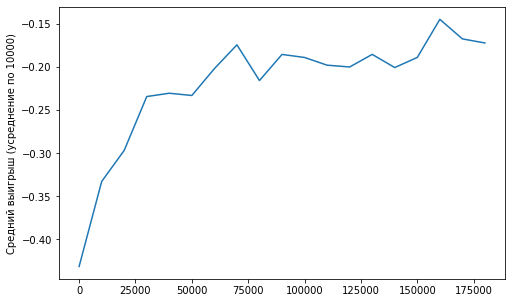

In [128]:
result_raw, pi_raw, env_raw, Q_raw = Q_learning(env=CardsCountDoubleBlackjackEnv(natural=True),
                                                get_s=get_s_basic,
                                                total_episodes=200000,
                                                alpha=0.005,
                                                epsilon=0.25,
                                                gamma=0.01)

plt.figure(figsize=(8,5))
plt.plot([i * 10000 for i in range(len(result_raw))], result_raw)
ax[0].set_xlabel('Количество игр')
plt.ylabel('Средний выигрыш (усреднение по 10000)')
plt.show()

In [129]:
result = calculate_MC_reward(num_starts=1000000,
                    env=CardsCountDoubleBlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_raw)

100%|██████████| 1000000/1000000 [01:47<00:00, 9261.06it/s]


In [116]:
print('\nMean result:{}'.format(np.array(result).mean()))


Mean result:-0.035443


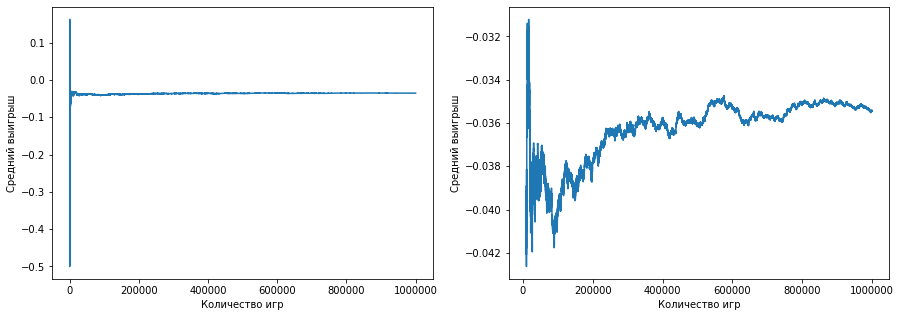

In [117]:
cum_sum = np.cumsum(result)
iters = np.arange(1, cum_sum.shape[0] + 1)
cum_mean = cum_sum / iters

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(iters, cum_mean)
ax[0].set_xlabel('Количество игр')
ax[0].set_ylabel('Средний выигрыш')

ax[1].plot(iters[10000:], cum_mean[10000:])
ax[1].set_xlabel('Количество игр')
ax[1].set_ylabel('Средний выигрыш');

Скорее всего, не хватило итераций для обучения

## Блэкдек с double и split

In [133]:
#####################################################
##    BlackjackEnv with double and split action    ##
#####################################################


class DoubleSplitBlackjackEnv(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # double action added
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(12)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def split_possible(self):
        return len(self.player) != len(set(self.player)) and len(self.player) == 2
    
    def split_obs(self):
        if self.split_possible():
            s = self.player[0]
        else:
            s = 0
        return s

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0: # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: # double
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        elif action == 3: # split
            done = False
            if self.split_possible():
                self.player = self.player[: -1] # delete paired card
                self.multiplier = 2
        else:
            pass
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.split_obs())

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [136]:
def Q_learning(env, get_s, total_episodes, alpha, epsilon, gamma, has_split=False):
    na = env.action_space.n
    ns = reduce(mul, [dimention.n for dimention in env.observation_space])

    Q = np.random.random(size=(ns, na))

    split_impossible_list = [get_s((i, j, k, 0), env) for i in range(env.observation_space[0].n) for j in range(env.observation_space[1].n) for k in range(env.observation_space[2].n) ]
    split_impossible_index = np.array([[0, 0, i] in split_impossible_list for i in range(ns) ])
    Q[split_impossible_index] = -100000000000

    pi = compute_policy_by_Q(env, Q)
    result = []
    rew = []

    for n in tqdm(range(total_episodes)):
        rew.append(Q_learning_episode(env, pi, Q, get_s, na, alpha=alpha, epsilon=epsilon, gamma=gamma))
        pi = compute_policy_by_Q(env, Q)
        if n % 10000 == 0 and n > 0:
            result.append(np.mean(rew))
            rew = []
    pi = compute_policy_by_Q(env, Q)

    return result, pi, env, Q

In [137]:
def get_s_basic(s, env):
    return s[0] - 1 + env.observation_space[0].n * (s[1]-1) +\
        env.observation_space[0].n * env.observation_space[1].n * s[2] +\
        env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n * s[3]

100%|██████████| 1000000/1000000 [05:56<00:00, 2801.71it/s]


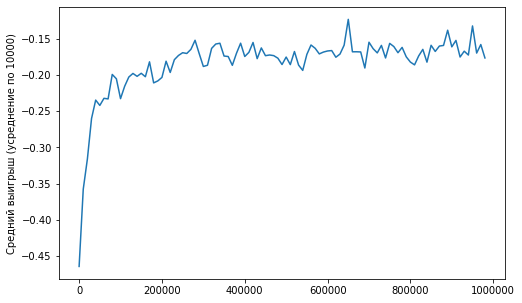

In [138]:
result_raw, pi_raw, env_raw, Q_raw = Q_learning(env=DoubleSplitBlackjackEnv(natural=True),
                                                get_s=get_s_basic,
                                                total_episodes=1000000,
                                                alpha=0.005,
                                                epsilon=0.25,
                                                gamma=0.01)

plt.figure(figsize=(8,5))
plt.plot([i * 10000 for i in range(len(result_raw))], result_raw)
ax[0].set_xlabel('Количество игр')
plt.ylabel('Средний выигрыш (усреднение по 10000)')
plt.show()

In [139]:
result = calculate_MC_reward(num_starts=1000000,
                    env=CardsCountDoubleBlackjackEnv(natural=True),
                    get_s=get_s_basic,
                    pi=pi_raw)

100%|██████████| 1000000/1000000 [01:33<00:00, 10737.26it/s]


In [140]:
print('\nMean result:{}'.format(np.array(result).mean()))


Mean result:-0.020188


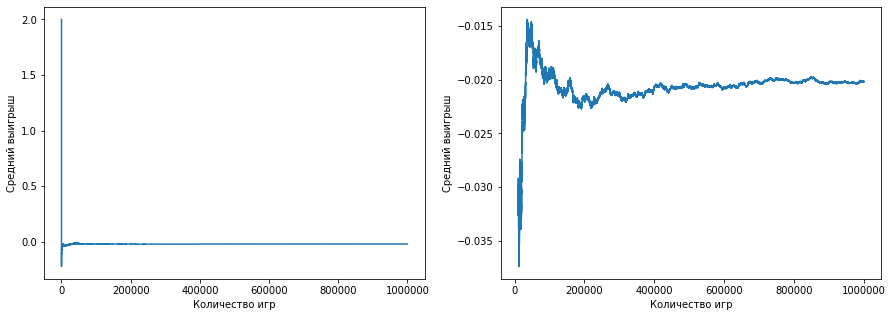

In [141]:
cum_sum = np.cumsum(result)
iters = np.arange(1, cum_sum.shape[0] + 1)
cum_mean = cum_sum / iters

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(iters, cum_mean)
ax[0].set_xlabel('Количество игр')
ax[0].set_ylabel('Средний выигрыш')

ax[1].plot(iters[10000:], cum_mean[10000:])
ax[1].set_xlabel('Количество игр')
ax[1].set_ylabel('Средний выигрыш');

Итог: лучший результат с double